In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.base import clone, BaseEstimator, TransformerMixin

from sklearn.metrics.pairwise import rbf_kernel

from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans

In [2]:
housing = pd.read_csv("files/housing.csv")

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

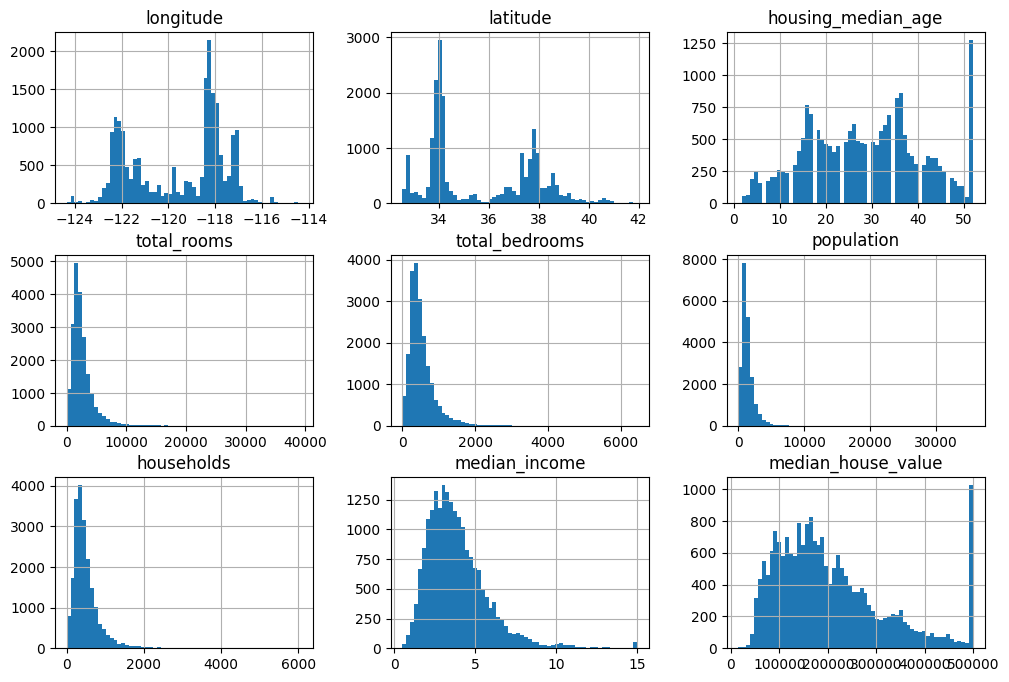

In [3]:
housing.hist(bins= 60, figsize=(12,8))

In [5]:
# removing upper capping records

i = housing.housing_median_age != 52.0
df_new = housing[i]
df_new = df_new[df_new.median_house_value != 500001.0]
df_new.shape

(18572, 10)

In [8]:
housing = df_new

## Required Preprocessing-

1. missing_value
2. scale
3. log Transformation --> for power law distribution
4. similarity to cluster  --> similarity with cluster centers_ in data
5. multimodes  --> similarity with peaks using rbf_kernel
6. num_to_category  --> OneHot 
7. Bucketization --> num labels for normal distribution,  and categorical value for multimodes distribution

In [12]:
# num pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy= "median")),
    ("scale", StandardScaler(with_mean= True)),
])

In [13]:
# cat pipeline

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy= "most_frequent")),
    ("onehot", OneHotEncoder(sparse= False))
])

In [16]:
# ratio transformation

def ratio(X):
    return X[:,[0]]/X[:,[1]]

def column_name(function_transformer, get_fetures_in):
    return ["ratio"]

ratio_pipeline = Pipeline([
    ("simpleimputer", SimpleImputer(strategy= "median")),
    ("ratio", FunctionTransformer(func= ratio, feature_names_out = column_name)),
    ("standardscaler", StandardScaler(with_mean= True))
])

In [20]:
# cluster similarity

class Similarity4Cluster(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters = 10, gamma = 0.1, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, sample_weight= None, y=None, ):
        self.kmeans_ = KMeans(n_clusters= self.n_clusters, random_state= self.random_state)
        self.kmeans_.fit(X, sample_weight= sample_weight)
        
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma= self.gamma)
    
    def get_feature_names_out(self,name = None):
        return [f"similarity with {i+1} cluster"  for i in range(self.n_clusters)]

In [21]:
# log transformation

log_pipeline = Pipeline([
    ("simpleimputer", SimpleImputer(strategy= "median")),
    ("log", FunctionTransformer(np.log, feature_names_out= "one-to-one")),
    ("standardscaler", StandardScaler(with_mean= True))
])

In [25]:
# multimodes distribution

def similarity_clms(function_transformer, get_features_in):
    return ["Similarity With Housing age: 35"]

    

simil = Pipeline([
    ("impute", SimpleImputer(strategy= "median")),
    ("similarity", FunctionTransformer(func= rbf_kernel, kw_args= dict(Y= [[35]], gamma= 0.1), feature_names_out= similarity_clms)),   #similarity with 35
    ("standardscaler", StandardScaler())
])

In [36]:
# final Preprocessing

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline, ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", Similarity4Cluster(), ["latitude", "longitude"]),
    ("cat", cat_pipeline, ["ocean_proximity"]),
    ("simil", simil, ["housing_median_age"]),
    ("pass", "passthrough", ["median_house_value"])
],
remainder = num_pipeline
)

In [37]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [42]:
arr = preprocessing.fit_transform(housing)

C:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [40]:
clms = preprocessing.get_feature_names_out()

In [43]:
df = pd.DataFrame(arr, columns= clms)

In [44]:
df

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__similarity with 1 cluster,geo__similarity with 2 cluster,...,geo__similarity with 8 cluster,geo__similarity with 9 cluster,geo__similarity with 10 cluster,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,simil__Similarity With Housing age: 35,pass__median_house_value
0,-1.120484,0.683184,-0.051154,-1.690992,-1.166625,-1.760937,-1.611414,2.059417,0.211999,0.982399,...,0.023634,0.816963,0.972873,0.0,0.0,0.0,1.0,0.0,-0.482880,452600.0
1,-0.968987,0.364089,-0.092380,1.303991,1.654793,0.993679,1.431735,2.052898,0.215638,0.984202,...,0.024234,0.815077,0.970551,0.0,0.0,0.0,1.0,0.0,-0.565655,358500.0
2,0.750397,-0.467458,-0.100053,0.594907,0.273804,0.049588,0.535048,-1.098130,0.213735,0.984131,...,0.023710,0.805285,0.970662,0.0,0.0,0.0,1.0,0.0,-0.543096,226700.0
3,0.625400,-0.489570,-0.043329,-0.595926,-0.840721,-0.702145,-0.588617,-1.049832,0.212479,0.983447,...,0.023525,0.807029,0.971609,0.0,0.0,0.0,1.0,0.0,-0.565655,140000.0
4,-0.188610,-0.018513,-0.068986,0.065951,0.095389,-0.221007,0.050120,-1.198028,0.213735,0.984131,...,0.023710,0.805285,0.970662,0.0,0.0,0.0,1.0,0.0,-0.565655,158700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18567,0.163716,-0.146076,-0.050687,-0.207304,-0.304899,-0.438142,-0.280058,-1.753176,0.099832,0.614902,...,0.013236,0.966778,0.719439,0.0,1.0,0.0,0.0,0.0,-0.565518,78100.0
18568,0.008747,0.311005,0.001314,-1.480766,-1.481684,-1.623310,-1.749808,-0.628626,0.095437,0.625903,...,0.012006,0.968425,0.741339,0.0,1.0,0.0,0.0,0.0,-0.565655,77100.0
18569,0.008171,-0.077599,-0.072420,0.154951,0.104412,-0.197663,0.095568,-1.557925,0.100492,0.641899,...,0.012735,0.974747,0.753367,0.0,1.0,0.0,0.0,0.0,-0.565655,92300.0
18570,0.085839,-0.024571,-0.091144,-0.082610,-0.155230,-0.618214,-0.202651,-1.344318,0.097300,0.652050,...,0.011821,0.974697,0.772060,0.0,1.0,0.0,0.0,0.0,-0.565655,84700.0


array([[<Axes: title={'center': 'bedrooms__ratio'}>,
        <Axes: title={'center': 'rooms_per_house__ratio'}>,
        <Axes: title={'center': 'people_per_house__ratio'}>,
        <Axes: title={'center': 'log__total_bedrooms'}>,
        <Axes: title={'center': 'log__total_rooms'}>],
       [<Axes: title={'center': 'log__population'}>,
        <Axes: title={'center': 'log__households'}>,
        <Axes: title={'center': 'log__median_income'}>,
        <Axes: title={'center': 'geo__similarity with 1 cluster'}>,
        <Axes: title={'center': 'geo__similarity with 2 cluster'}>],
       [<Axes: title={'center': 'geo__similarity with 3 cluster'}>,
        <Axes: title={'center': 'geo__similarity with 4 cluster'}>,
        <Axes: title={'center': 'geo__similarity with 5 cluster'}>,
        <Axes: title={'center': 'geo__similarity with 6 cluster'}>,
        <Axes: title={'center': 'geo__similarity with 7 cluster'}>],
       [<Axes: title={'center': 'geo__similarity with 8 cluster'}>,
      

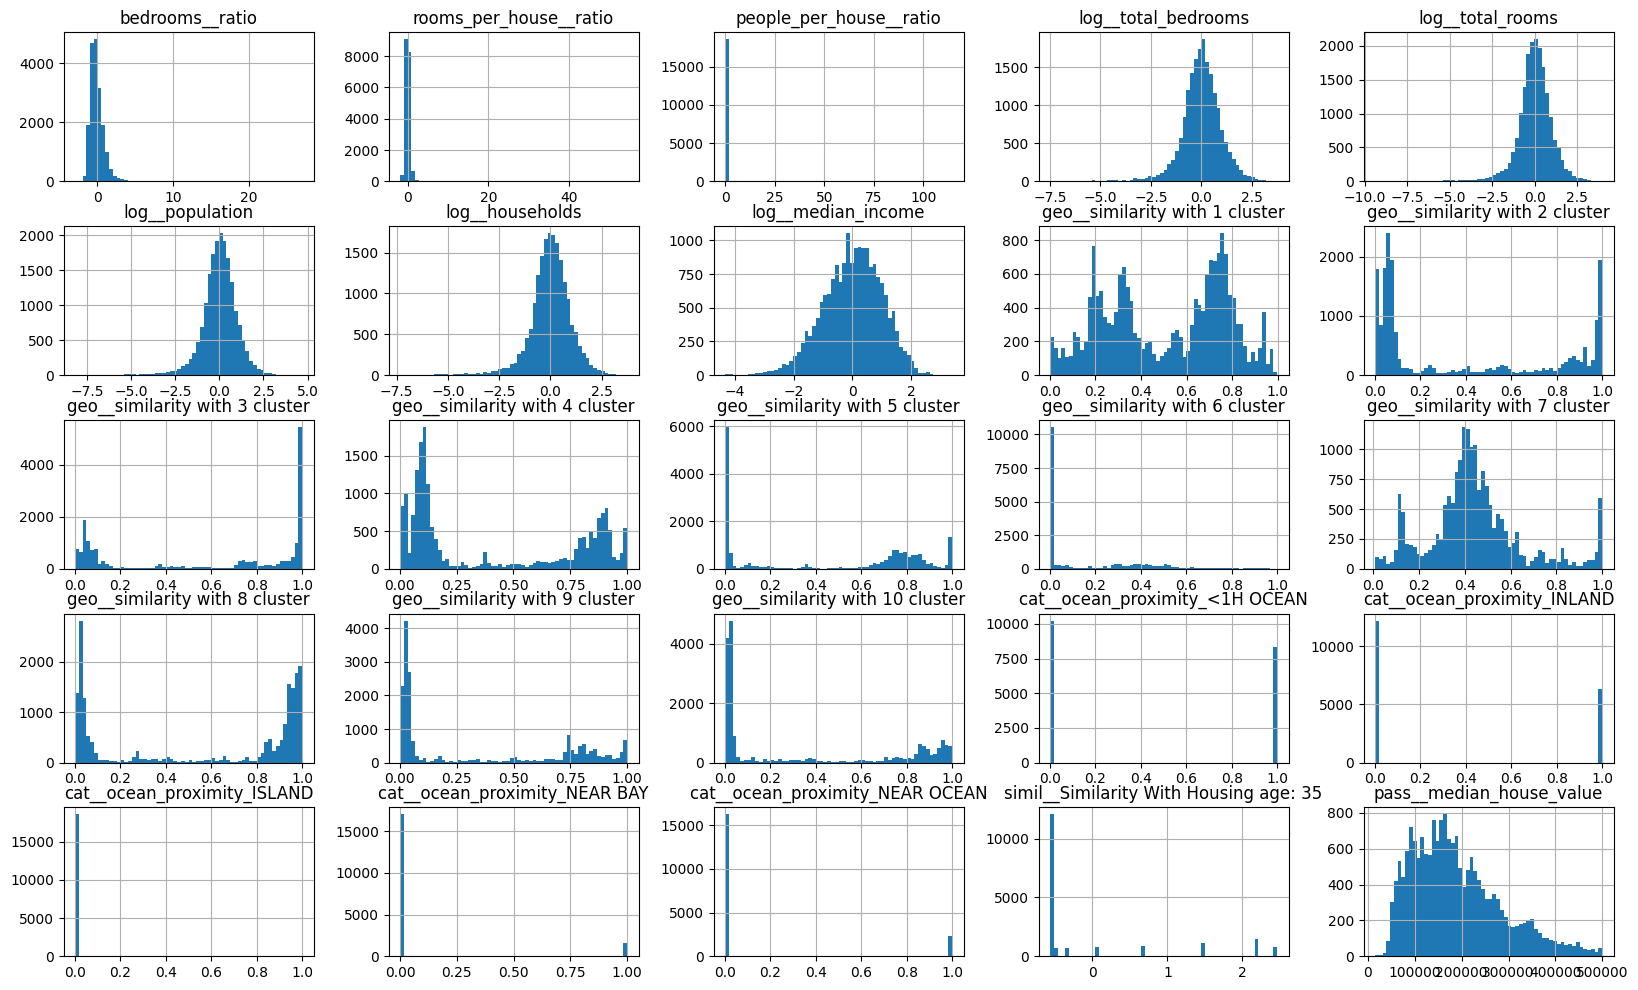

In [47]:
df.hist(bins =60, figsize= (20,12))